In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler

In [10]:
file_path = '/content/data.csv'
data = pd.read_csv(file_path)

In [11]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-10, 1.0)
    n_restarts_optimizer = trial.suggest_categorical('n_restarts_optimizer', [0, 5, 10])
    length_scale = trial.suggest_loguniform('length_scale', 1e-2, 1e2)

    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale, (1e-2, 1e2))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, alpha=alpha)

    # Fit the model
    gpr.fit(X_train, y_train)

    # Make predictions
    y_pred, _ = gpr.predict(X_test, return_std=True)

    # Evaluate the model
    score = r2_score(y_test, y_pred)
    return score

In [18]:
# Create the Optuna study
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)

[I 2024-07-21 14:12:00,686] A new study created in memory with name: no-name-f10137d4-fea8-4eb5-833b-73a45fd43307
<ipython-input-16-3292f3fc0330>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-10, 1.0)
<ipython-input-16-3292f3fc0330>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  length_scale = trial.suggest_loguniform('length_scale', 1e-2, 1e2)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better val

In [19]:
# Get the best parameters
best_params = study.best_params
print(f"Best Parameters: {best_params}")

Best Parameters: {'alpha': 0.9848736464421752, 'n_restarts_optimizer': 0, 'length_scale': 0.4215164226292127}


In [20]:
# Fit the best model with the best parameters
best_gpr = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2)) * RBF(best_params['length_scale'], (1e-2, 1e2)),
    n_restarts_optimizer=best_params['n_restarts_optimizer'],
    alpha=best_params['alpha']
)

In [21]:
# Fit the model
best_gpr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.9848736464421752,
                         kernel=1**2 * RBF(length_scale=0.422))

In [22]:
# Make predictions on the testing set
y_pred, sigma = best_gpr.predict(X_test, return_std=True)

In [23]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [24]:
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.007263372827824096
R^2 Score: -0.0007659286156320722


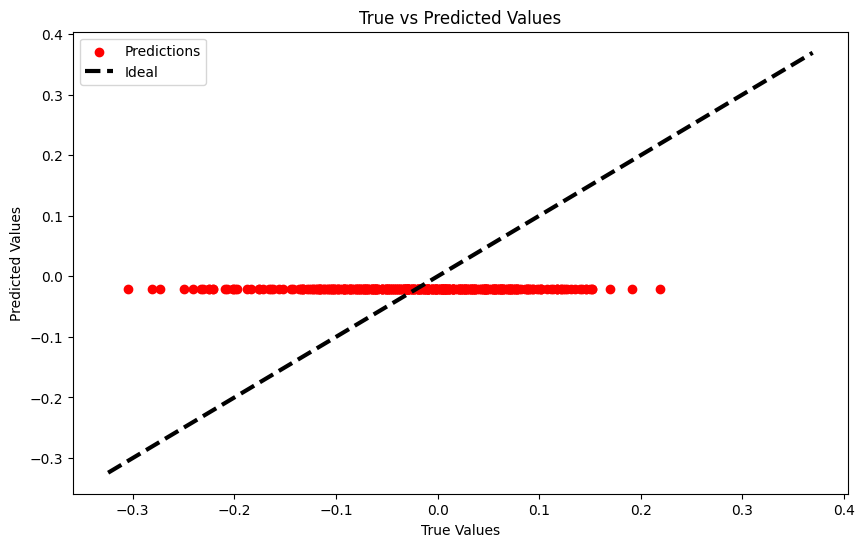

In [25]:
# Plot the predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c='r', marker='o', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

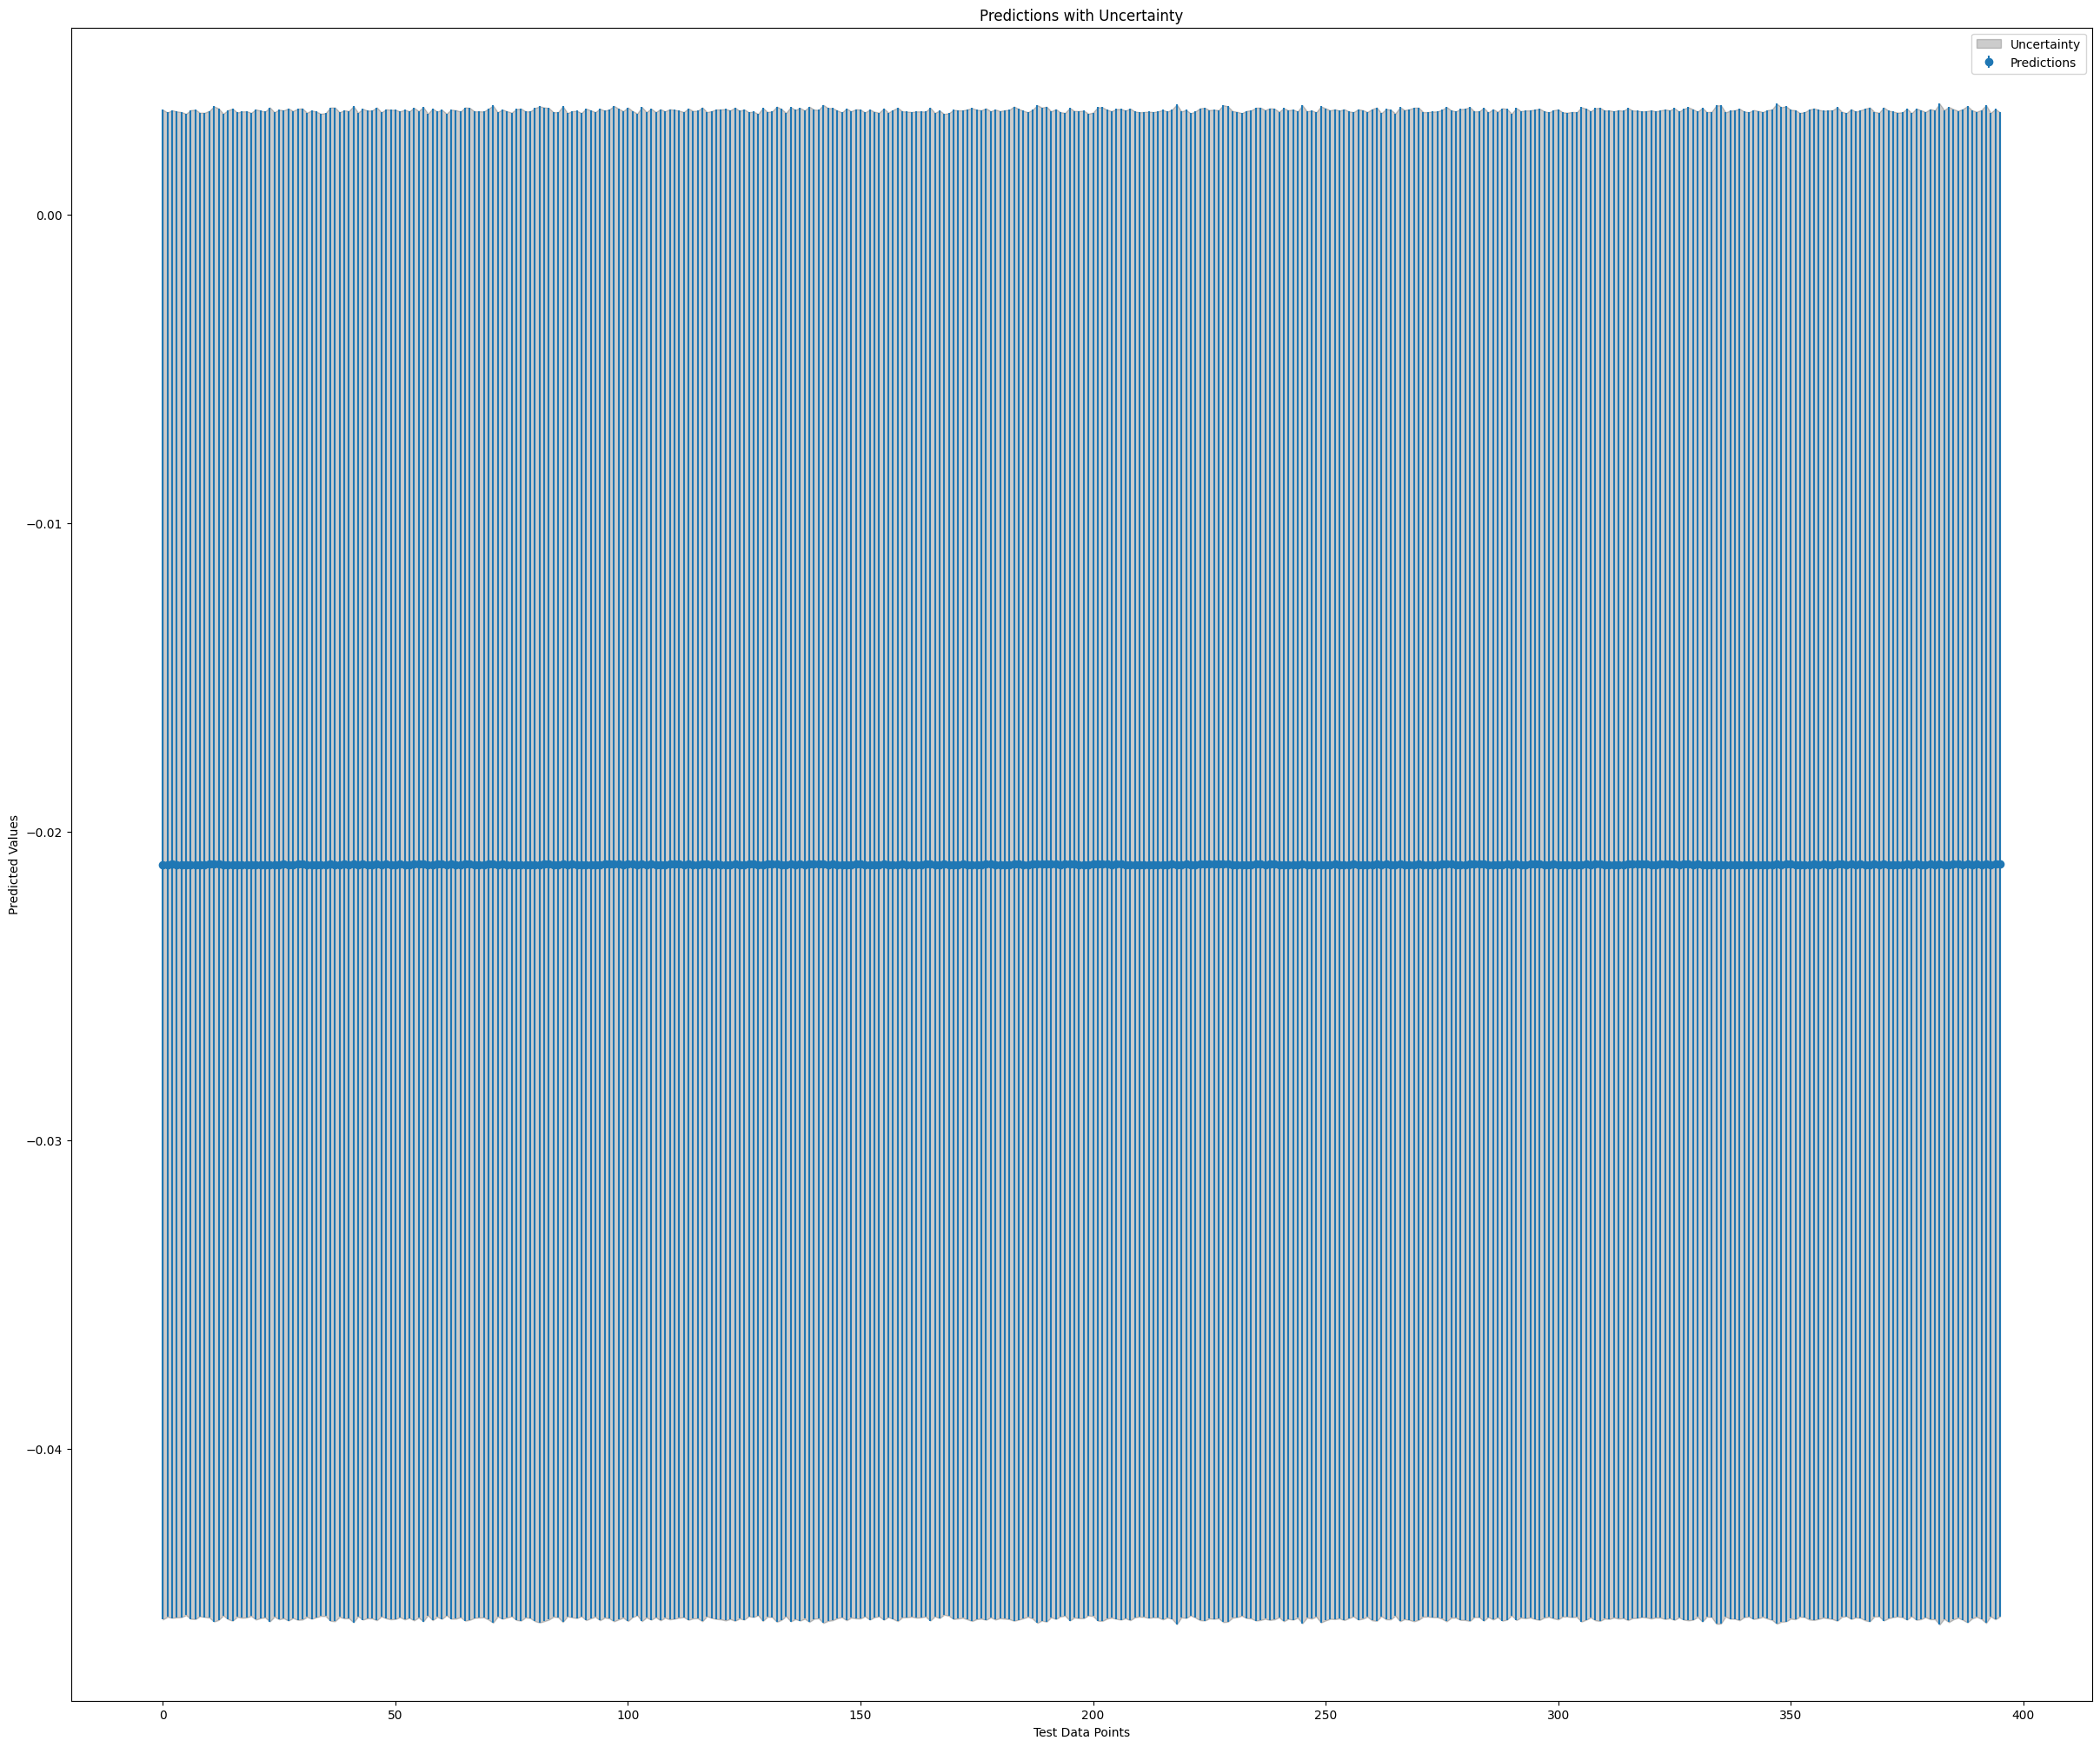

In [34]:
# Plot the prediction uncertainty
plt.figure(figsize=(30,25))
plt.errorbar(range(len(y_test)), y_pred, yerr=sigma, fmt='o', label='Predictions')
plt.fill_between(range(len(y_test)), y_pred - sigma, y_pred + sigma, alpha=0.2, color='k', label='Uncertainty')
plt.xlabel('Test Data Points')
plt.ylabel('Predicted Values')
plt.title('Predictions with Uncertainty')
plt.legend()
plt.show()